In [39]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [45]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 48                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 256                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
#input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
#input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
#input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')

input_names   = list()
#input_names.append('TKE+IDEMIX, jayne')
#input_names.append('TKE+IDEMIX, nycander')
#input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')
# input_names.append('Tido Test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl         = None
do_allcycl     = False 
vname          = 'vec+u+v' # vel on elem: vec+u+v, vel on vertices: vec+unod+vnod
year           = [1958, 2019]
mon            = None
day            = None
record         = None 
box            = None
depth          = None
do_edgevec_r2g = True  
do_datavec_r2g = True  # set to False if u,v data are already in geo-coordinates
do_bolus       = True  # add bolus velocity to vec+u+v

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Transects via [ [lon], [lat], transect-name, inverse_direction (True, optional) ]__
input_transect = list()
input_transect.append([[-66, -66],[-67, -55], 'Drake Passage', False])

# input_transect.append([[ -30,  -30],[-80, 90], '30°W, 80°S-90°N', False])

# input_transect.append([[-170, -170],[-80, 90], '-170°W, -80-90°N', False])

# input_transect.append([[-56.5,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
#                        [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
#                        'OSNAP', False])

# input_transect.append([[-56.5,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0],
#                        [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4], 
#                        'OSNAP-West', False])

# input_transect.append([[-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
#                        [ 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
#                        'OSNAP-East', False])

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
plt_opt           = dict({'marker':'o'})
do_concat         = False 
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
do_std            = False
save_dpi          = 300
save_fmt          = ['png']

# these parameters are not needed here but need to be defined for papermill 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None

In [41]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem)

Connected to existing Dask cluster: <Client: 'tcp://127.0.0.1:39139' processes=48 threads=48, memory=238.40 GiB>


<Client: 'tcp://127.0.0.1:39139' processes=48 threads=48, memory=238.40 GiB>

In [42]:
#___LOAD FESOM2 MESH_______________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, _ , _ = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path is not None): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record    
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
#     ref_cinfo['cref']=0.0
    
# #______________________________________________________________________________________________________    
# # concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
# input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 'auto', 
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : 'auto', 
               'nz'   : 'auto',
               'edg_n': 'auto'})       

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /home/a/a270042/meshcache_tripyview/dart
 > load  *.jlib file: tripyview_fesom2_dart_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /work/ba1264/a270210/model/input/fesom2/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 80
___________________________________________


 --> Load: fesom.mesh.diag.nc --> elasped time: 0.03343213399251302 min.
Drake Passage


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/feature/__init__.py:217: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  self._geoms = tuple(geometries)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/feature/__init__.py:217: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  self._geoms = tuple(geometries)


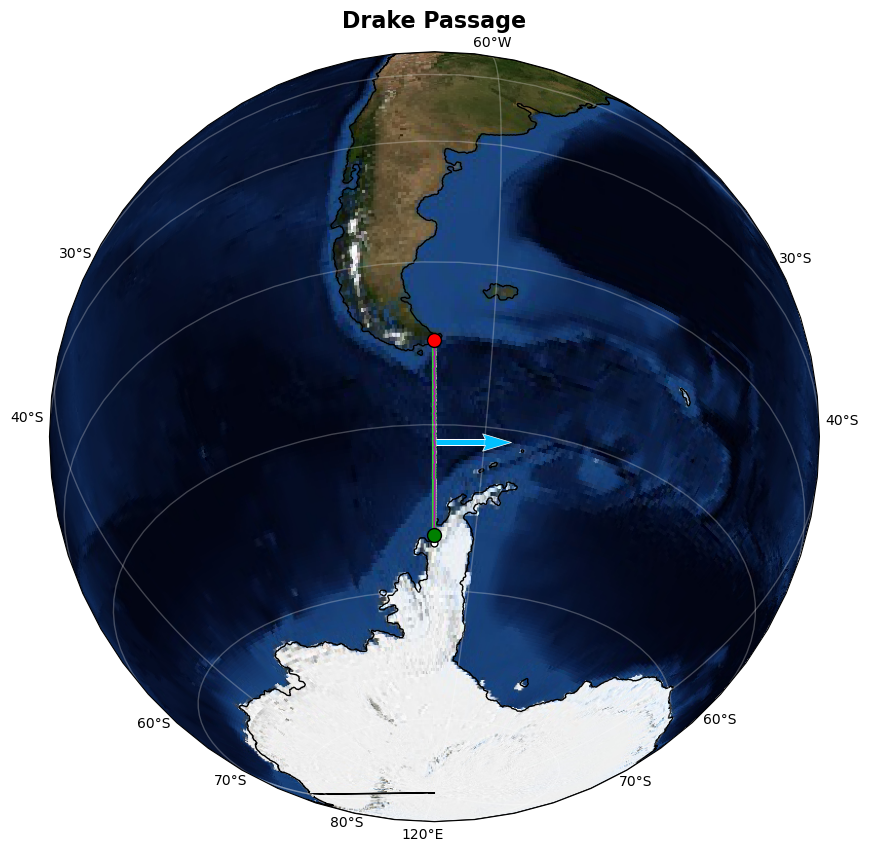

 --> Analyse transects --> elasped time: 0.05273617108662923 min.


In [43]:
#______________________________________________________________________________________________________    
# load information about edges 
ts = clock.time()
datapath = input_paths[0]
fname    = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    

#___________________________________________________________________________
# set specfic type when loading --> #convert to specific precision
# drop unnecessary variables:  Based on the documentation (but a bit hidden), 
# the "data_vars=" argument only works with Python 3.9.
from functools import partial
var_keep = ['edges', 'edge_tri', 'edge_cross_dxdy', 'nod_in_elem2D', 'edge_nodes', 'edge_face_links' ]
def _preprocess(x):
    for var in list(x.keys()):
        if var not in var_keep: 
            x = x.drop_vars(var)
            continue
            
        if x[var].dtype=='float64': x[var] = x[var].astype('float32')
        # there were some changings in the fesom.mesh.diag.nc variable naming from fesom 2.5-->2.6
        # for some reason he load now edge_nodes and edge_face_links as float32, while they cant
        # be used as indices by default and need to be converted by hand into int32
        if   var in ['edge_nodes'     ]: x = x.rename({'edge_nodes'     :'edges'})#.astype('int32')                
        elif var in ['edge_face_links']: x = x.rename({'edge_face_links':'edge_tri'})#.astype('int32')                
    return x
partial_func = partial(_preprocess)

#___________________________________________________________________________
# load diag file --> apply drop variables by preprocessor function
# decode_cf=False is need so that the original fillvalue of -999 is used instead of NaN
# or np.iinfo(np.int32).max()
mdiag = xr.open_mfdataset(os.path.join(dname,fname), parallel=False, 
                             chunks=dict({'edg_n':'auto'}), engine='netcdf4', 
                             preprocess=partial_func,  decode_cf=False)
mdiag = mdiag.drop_vars(list(mdiag.coords)).load()

# node indices of edge points [2 x n2ded]
edge       = mdiag['edges'].values-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
edge_tri   = mdiag['edge_tri'].values-1
# dx & dy of edge midpoints towards element centroid of left and right triangle
edge_dxdy  = mdiag['edge_cross_dxdy'].values[:]

# # Be sure that the edge_cross_dxdy variable is in the same rotational frame as your velocities. By default
# # edge_cross_dxdy is in rotated coordinates. So if you velocities are also in rotated coordinates things are fine.
# # If your velocities should be in geo coordinates than edge_cross_dxdy needs to be rotated as well into geo
# # coordinates (do_edgevec_r2g=True)
# if (do_edgevec_r2g):
#     edm_x = mesh.n_x[edge].sum(axis=0)/2.0
#     edm_y = mesh.n_y[edge].sum(axis=0)/2.0
#     edge_dxdy[0,:], edge_dxdy[1,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[0,:], edge_dxdy[1,:], gridis='geo', do_info=False )
#     edge_dxdy[2,:], edge_dxdy[3,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[2,:], edge_dxdy[3,:], gridis='geo', do_info=False )
#     del(edm_x, edm_y)
    
# [L]eft  triangle: dx, dy
edge_dxdy_l= np.array([ edge_dxdy[0,:], edge_dxdy[1,:]])
# [R]ight triangle: dx, dy
edge_dxdy_r= np.array([ edge_dxdy[2,:], edge_dxdy[3,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0. # if boundarie edge --> right triangle doesnot exist
del(edge_dxdy)

# only needed for plotting transects when scalar data are on elements, here temp and salt are on vertices
nodeinelem = mdiag['nod_in_elem2D'].values[:,:]-1
print(' --> Load: fesom.mesh.diag.nc --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))

#______________________________________________________________________________________________________    
# analyse transects computes all neccesary arrays
ts = clock.time()
transects = tpv.do_analyse_transects(input_transect, mesh, edge, edge_tri, edge_dxdy_l, edge_dxdy_r, do_rot=do_edgevec_r2g, do_info=False)
for transect in transects:
    print(transect['Name'])
    fig, ax = tpv.plot_transect_position(mesh, transect, edge=edge, do_grid=False)# zoom=100)

print(' --> Analyse transects --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))

In [46]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
data_list, data_list_plus, data_list_minus = list(), list(), list()
# if you do more than 1 transect at ones its better to pre load the data before extracting the transect
# but might need a bit more memory
do_persist = len(transects) > 1

year_list    = list(range(year[0], year[1]+1))
chnk_size    = 10 # compute dmoc time-series in chunks of chnk_size years
chnk_yrs_list= year_list[::chnk_size]

#___LOAD FESOM2 DATA___________________________________________________________________________________
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    print(' > year:', end='')
    
    # compute time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    transp_t, transp_t_plus, transp_t_minus = list(), list(), list()
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        ts = clock.time()
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='')
        
        #____________________________________________________________________________________________________
        # load u and v data in rotated coordinates
        data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year_chnk, mon=mon, descript=descript,
                                     do_rot=False, do_info=False, do_tarithm=None, do_zarithm='None', chunks=chunks, 
                                     do_ie2n=False, do_nan=False, do_load=False, do_persist=do_persist, do_parallel=do_parallel)
        #____________________________________________________________________________________________________    
        # check if data where loaded
        if data is None: raise ValueError(f'data == None, {vname} data could not be read, your path:{datapath} might be wrong!!!')
        
        #____________________________________________________________________________________________________    
        if do_bolus and vname == 'vec+u+v':
            data['u'].data = data['u'].data + tpv.load_data_fesom2(mesh, datapath, vname='bolus_u', year=year_chnk, descript=descript, 
                                                                   do_info=False, do_rot=False, do_zarithm='None', do_ie2n=False,
                                                                   chunks=chunks, do_compute=False, do_load=False, do_persist=do_persist, #do_persist=False, 
                                                                   do_parallel=do_parallel)['bolus_u'].data
            data['v'].data = data['v'].data + tpv.load_data_fesom2(mesh, datapath, vname='bolus_v', year=year_chnk, descript=descript, 
                                                                   do_info=False, do_rot=False, do_zarithm='None', do_ie2n=False,
                                                                   chunks=chunks, do_compute=False, do_load=False, do_persist=do_persist, #do_persist=False, 
                                                                   do_parallel=do_parallel)['bolus_v'].data
            del(data_bv)
        
        #____________________________________________________________________________________________________
        # compute transport through section 
        transp = tpv.calc_transect_Xtransp(mesh, data, transects, do_rot=do_datavec_r2g, do_info=False)  # compute Volume transport
        del(data)
        
        #____________________________________________________________________________________________________
        # compute time-series
        for ii, transp_i in enumerate(transp):
            vnameX = list(transp_i.data_vars)[0]
            vnameX_p, vnameX_m = vnameX+'_plus', vnameX+'_minus'
            
            transp_ip = transp_i.where(transp_i[vnameX]>0).sum(dim=('npts','nz1'), skipna=True).rename({vnameX:vnameX_p }) 
            transp_ip[vnameX_p].attrs['long_name'] = transp_ip[vnameX_p].attrs['long_name'] + ' (+)'
            
            transp_im = transp_i.where(transp_i[vnameX]<0).sum(dim=('npts','nz1'), skipna=True).rename({vnameX:vnameX_m})
            transp_im[vnameX_m].attrs['long_name'] = transp_im[vnameX_m].attrs['long_name'] + ' (-)'
            
            transp_i  = transp_i.sum(dim=('npts','nz1'), skipna=True)
            
            if nchnk==0: 
                transp_t.append(transp_i)
                transp_t_plus.append(transp_ip)
                transp_t_minus.append(transp_im)
            else       : 
                transp_t[ii]       = xr.concat([transp_t[ii]      , transp_i ], dim='time')
                transp_t_plus[ii]  = xr.concat([transp_t_plus[ii] , transp_ip], dim='time')
                transp_t_minus[ii] = xr.concat([transp_t_minus[ii], transp_im], dim='time')
        
        #____________________________________________________________________________________________________
        del(transp)
        print(' --> elasped time: {:3.2f} min.'.format( (clock.time()-ts)/60  ), end='\n        ')     
        if client is not None: client.run(gc.collect)
    #________________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    data_list.append(transp_t)    
    data_list_plus.append(transp_t_plus)  
    data_list_minus.append(transp_t_minus)  
print(' --> total elasped time: {:3.2f} min.'.format( (clock.time()-t0)/60  ))  

/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/ Tido Test
 > year:1958|1959|1960|1961|1962|1963|1964|1965|1966|1967 --> elasped time: 0.80 min.
        1968|1969|1970|1971|1972|1973|1974|1975|1976|1977 --> elasped time: 0.79 min.
        1978|1979|1980|1981|1982|1983|1984|1985|1986|1987 --> elasped time: 0.81 min.
        1988|1989|1990|1991|1992|1993|1994|1995|1996|1997 --> elasped time: 0.83 min.
        1998|1999|2000|2001|2002|2003|2004|2005|2006|2007 --> elasped time: 0.80 min.
        2008|2009|2010|2011|2012|2013|2014 --> elasped time: 0.57 min.
         --> total elasped time: 4.60 min.


### --> Netto Transport

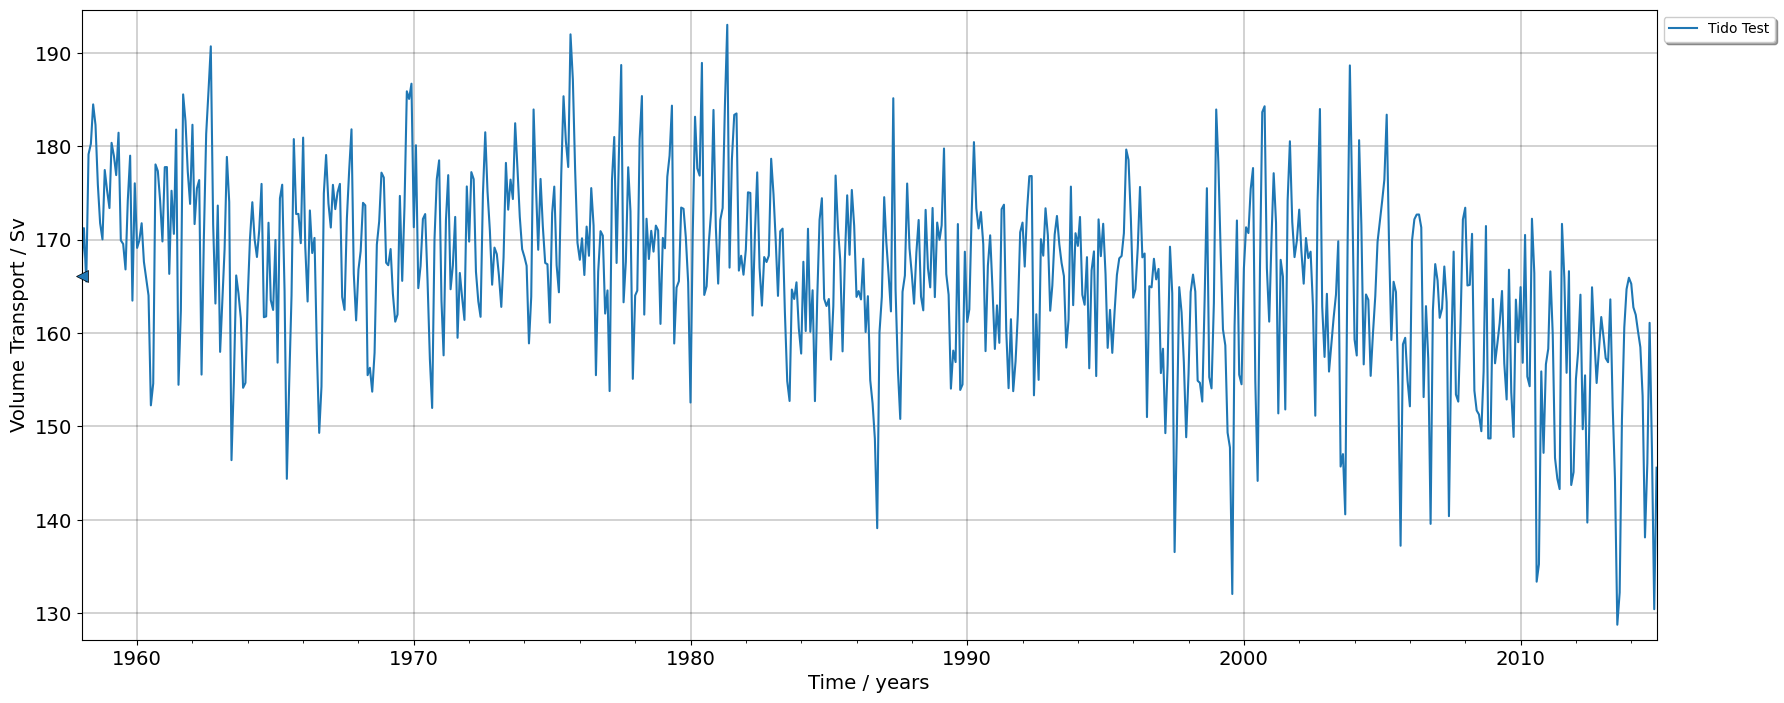

In [47]:
ntrs, ndat = len(transects), len(data_list)
for trs_idx in range(ntrs):
    
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(data_list[0][trs_idx].data_vars)[0]
    slabel = data_list[0][trs_idx][svname].attrs['str_lsave']
    stname = data_list[0][trs_idx][svname].attrs['transect_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'transect_t', stname ,slabel, sfmt)) )
    if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
   
    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(data_list, transects, nrow=1, ncol=1 , 
                            n_cycl     = n_cycl                  , 
                            do_allcycl = do_allcycl              , 
                            do_concat  = do_concat               , 
                            do_shdw    = do_shdw                 ,
                            do_mean    = do_mean                 ,
                            do_std     = do_std                  ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                            )  

### --> (+) Transport (North, East)

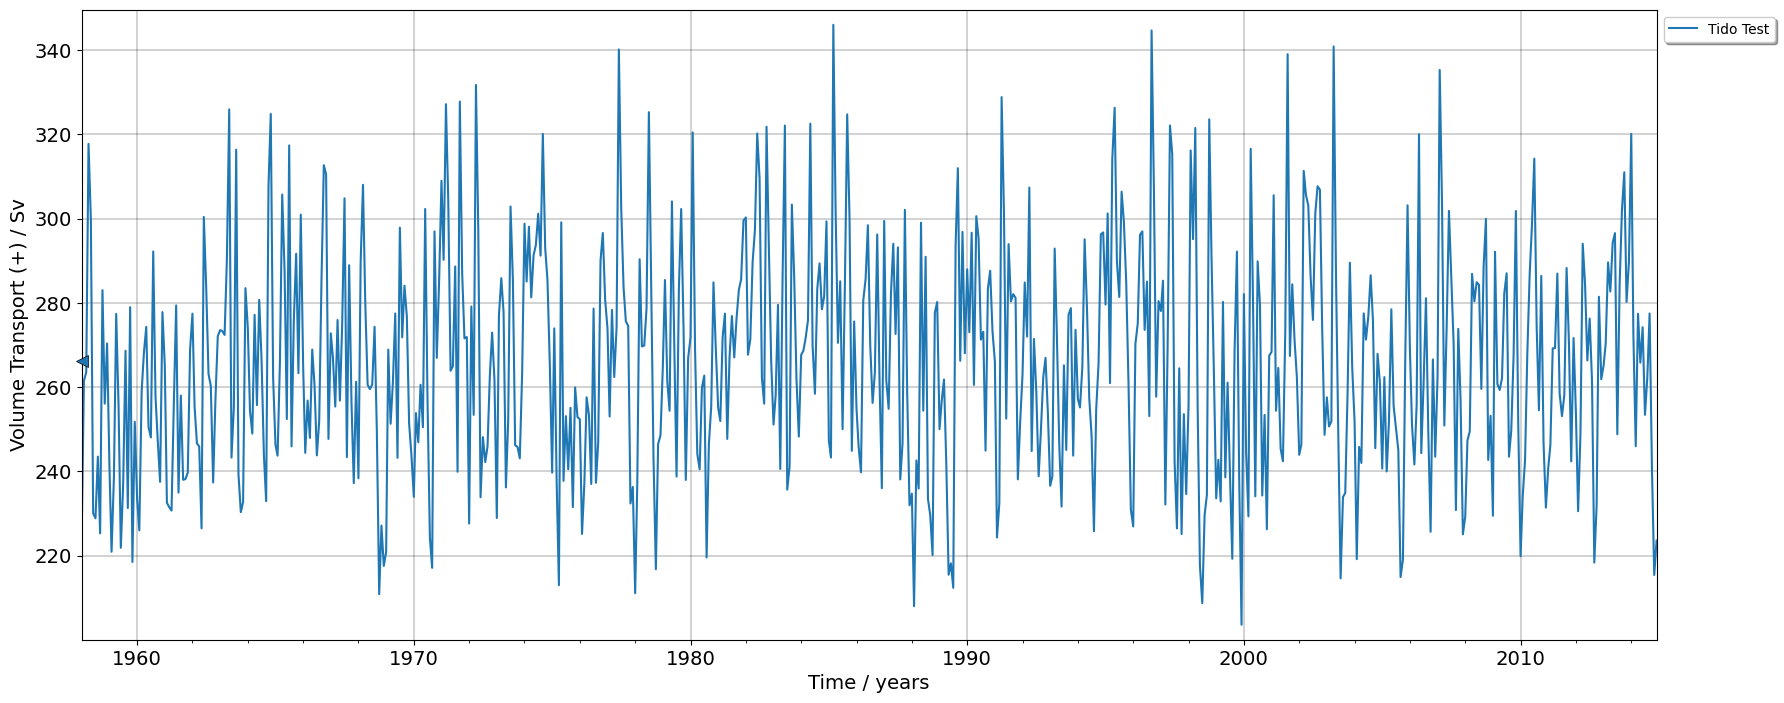

In [48]:
ntrs, ndat = len(transects), len(data_list)
for trs_idx in range(ntrs):
    
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(data_list[0][trs_idx].data_vars)[0]
    slabel = data_list[0][trs_idx][svname].attrs['str_lsave']
    stname = data_list[0][trs_idx][svname].attrs['transect_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'transect_t_plus', stname ,slabel, sfmt)) )
    if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
   
    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(data_list_plus, transects, nrow=1, ncol=1 , 
                            n_cycl     = n_cycl                  , 
                            do_allcycl = do_allcycl              , 
                            do_concat  = do_concat               , 
                            do_shdw    = do_shdw                 ,
                            do_mean    = do_mean                 ,
                            do_std     = do_std                  ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                            )  

### --> (-) Transport (South, West)

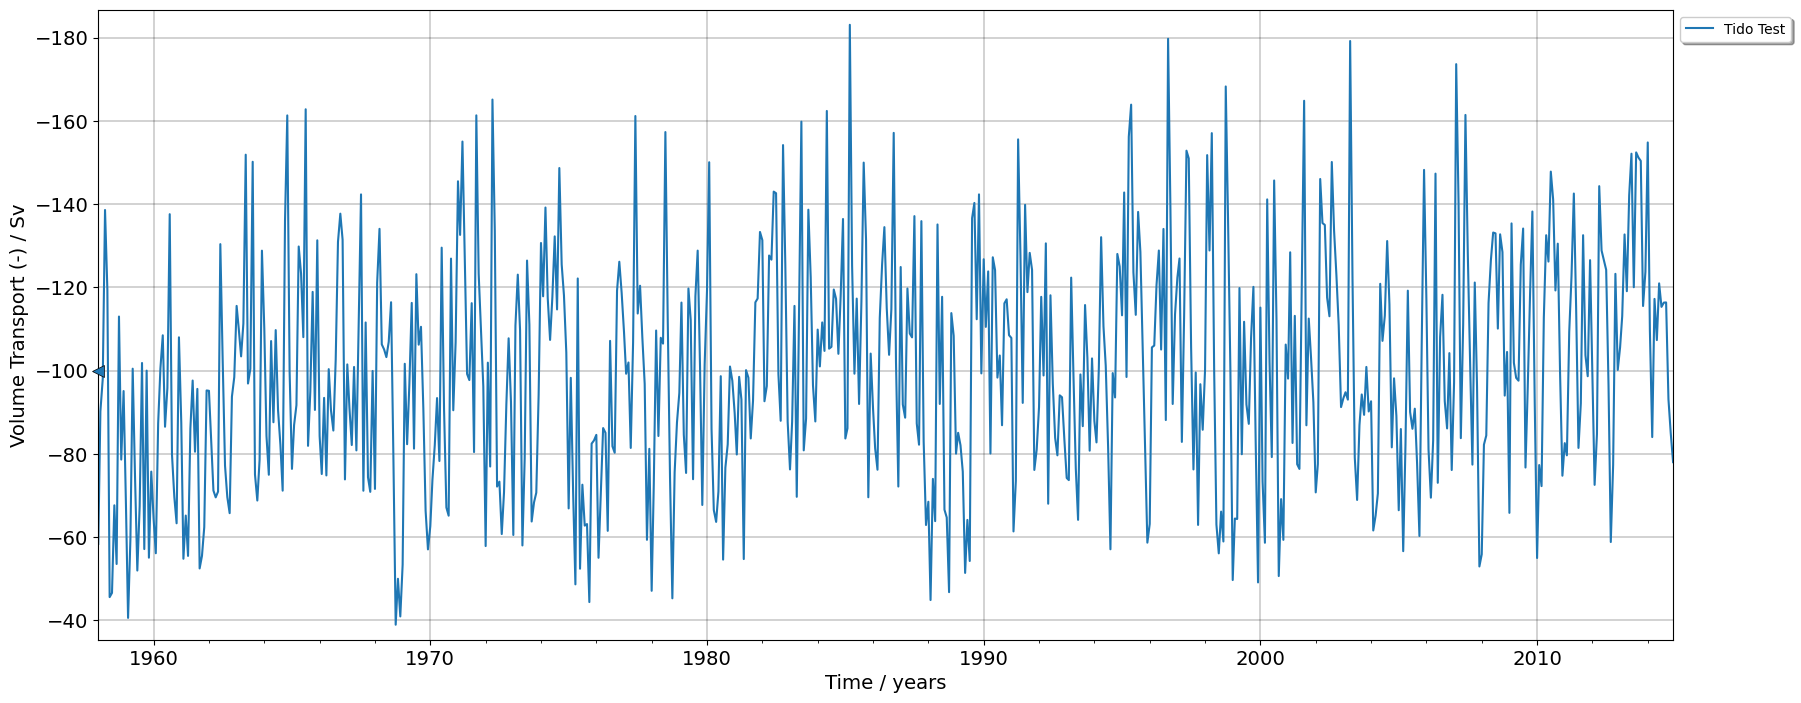

In [49]:
ntrs, ndat = len(transects), len(data_list)
for trs_idx in range(ntrs):
    
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(data_list[0][trs_idx].data_vars)[0]
    slabel = data_list[0][trs_idx][svname].attrs['str_lsave']
    stname = data_list[0][trs_idx][svname].attrs['transect_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'transect_t_minus', stname ,slabel, sfmt)) )
    if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
   
    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(data_list_minus, transects, nrow=1, ncol=1 , 
                            n_cycl     = n_cycl                  , 
                            do_allcycl = do_allcycl              , 
                            do_concat  = do_concat               , 
                            do_shdw    = do_shdw                 ,
                            do_mean    = do_mean                 ,
                            do_std     = do_std                  ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            grid_opt   = dict({'do_yinv':True} ) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                            )  

In [ ]:
if do_papermill and do_parallel and client is not None: client.shutdown()